In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

In [36]:
# UTILS

# Розрахунок RSI
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


def create_time_steps(length):
    return list(range(-length, 0))

# Розрахунок MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# PLOTS

# PREDICT PLOT
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

# PREDICT MULTI STEP PLOT
def multi_step_plot(history, true_future, prediction, step):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 2]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# train history LOSS
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [5]:
btc_data_df = pd.read_csv('BTC-USD_5Y.csv')
btc_data_df['rsi_14'] = get_rsi(btc_data_df['Close'], 14)
btc_data_df = btc_data_df.dropna()
btc_data_df.reset_index(drop=True, inplace=True)
btc_data_df.tail()

,Date,Open,High,Low,Close,Volume,rsi_14
1819,5/7/2024,63162.76172,64390.45703,62285.98047,62334.81641,2.593073e+10,45.781929
1820,5/8/2024,62332.64063,62986.08594,60877.12891,61187.94141,2.608817e+10,42.973872
1821,5/9/2024,61191.19922,63404.91406,60648.07422,63049.96094,2.545334e+10,48.497139
1822,5/10/2024,63055.19141,63446.74219,60208.78125,60792.77734,2.780495e+10,43.053404
1823,5/11/2024,60791.75781,61057.33203,60548.67578,60694.61328,2.510671e+10,42.828249


In [6]:
btc_data = btc_data_df[["Open", "Volume", "rsi_14"]]

# Створіть об'єкт StandardScaler
scaler = StandardScaler()

# Применяем масштабирование к каждой колонке и собираем их в новый DataFrame
scaled_df = pd.DataFrame()

# Стандартизуйте дані
for column in btc_data.columns:
    # Преобразуем колонку в двумерный массив
    column_data = btc_data[column].values.reshape(-1, 1)
    
    # Применяем fit_transform к колонке
    scaled_column_data = scaler.fit_transform(column_data)
    
    # Добавляем масштабированные данные обратно в DataFrame
    scaled_df[column] = scaled_column_data.flatten()

scaled_df.index = btc_data_df['Date']

display(pd.DataFrame(scaled_df, columns = scaled_df.columns, index= scaled_df.index).head())

,Open,Volume,rsi_14
Date,,,
5/15/2019,-1.182897,-0.133812,2.345041
5/16/2019,-1.171010,0.136149,1.051064
5/17/2019,-1.188834,-0.037398,-0.291230
5/18/2019,-1.220431,-0.525051,-0.426165
5/19/2019,-1.224702,-0.270480,0.891260


In [7]:
# Data Loader Parameters
split_fraction = 0.7
TRAIN_SPLIT = int(split_fraction * len(scaled_df))
BATCH_SIZE = 120
BUFFER_SIZE = 10000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 50
PATIENCE = 5

past_history = 14
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(scaled_df.values, scaled_df.iloc[:, 2], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP,
                                                  single_step=True)

x_val_single, y_val_single = multivariate_data(scaled_df.values, scaled_df.iloc[:, 2], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP,
                                                  single_step=True)

C:\Users\User\AppData\Local\Temp\ipykernel_9552\2890038787.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(target[i+target_size])


In [8]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(1262, 14, 3)
Single window of past history : (14, 3)
(14, 3)


In [9]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [10]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(16))
single_step_model.add(tf.keras.layers.Dense(8))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
single_step_model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(120, 1)


In [12]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 50
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5897 - val_loss: 0.3819
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3881 - val_loss: 0.3555
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3700 - val_loss: 0.3467
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3611 - val_loss: 0.3460
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3585 - val_loss: 0.3418
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3537 - val_loss: 0.3413
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3551 - val_loss: 0.3368
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3519 - val_loss: 0.3361
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3488 - val_loss: 0.3322
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3458 - val_loss: 0.3288
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3409 - val_loss: 0.3230
Epoch 12/50
200

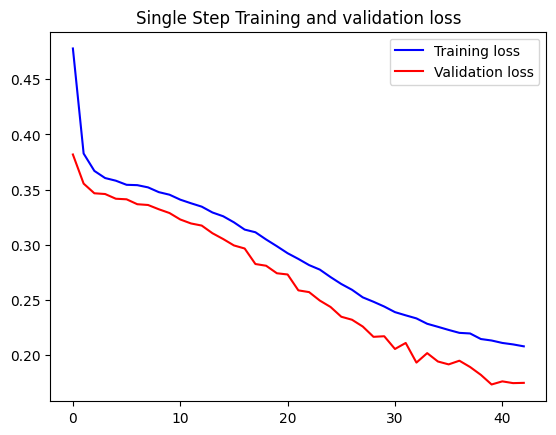

In [13]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


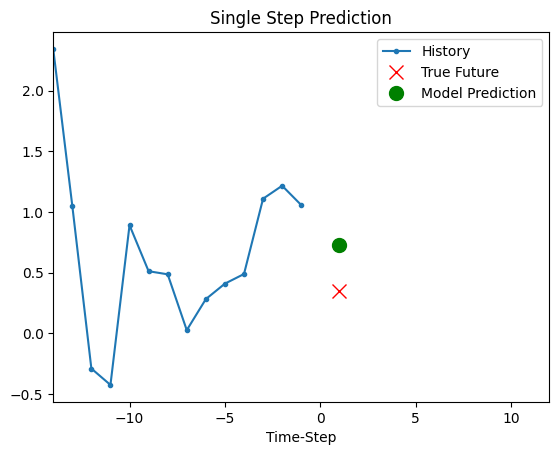

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


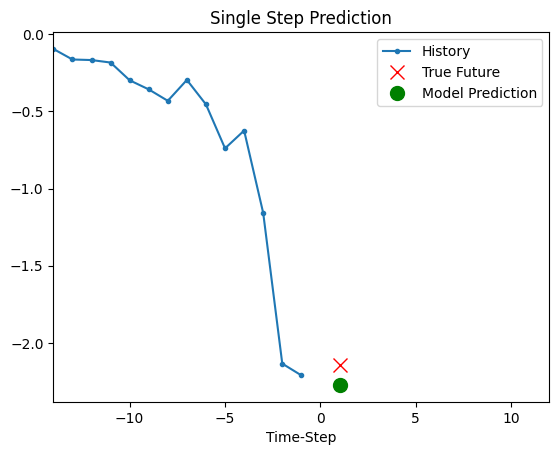

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


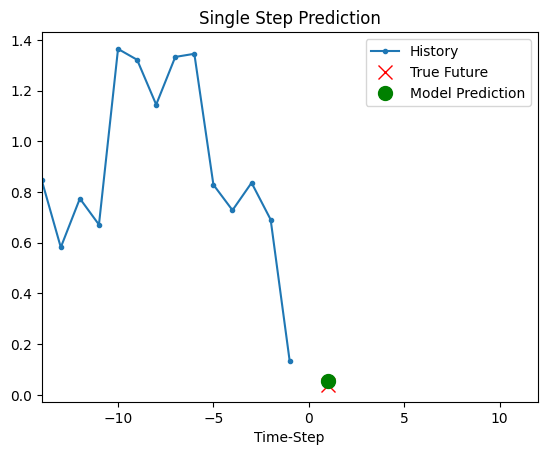

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


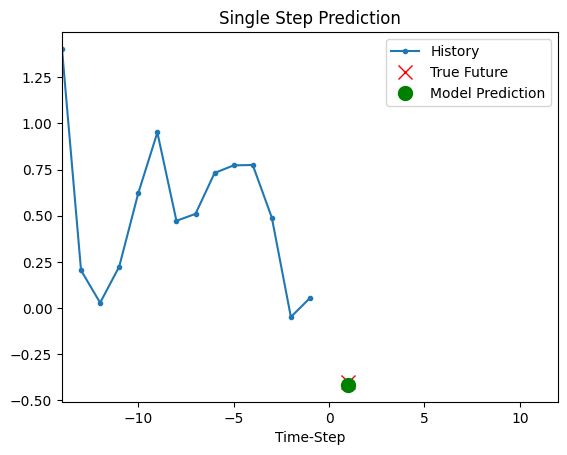

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


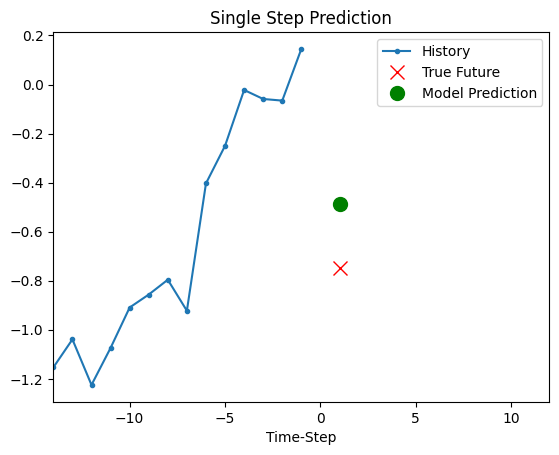

In [14]:
for x, y in val_data_single.take(5):
    plot = show_plot([x[0][:, 2].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
    plot.show()

In [15]:
past_history = 14
future_target = 3
STEP = 1

x_train_multi, y_train_multi = multivariate_data(scaled_df.values, scaled_df.iloc[:, 2], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(scaled_df.values, scaled_df.iloc[:, 2], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)


In [16]:
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(1262, 14, 3)
(1262, 3)
Single window of past history : (14, 3)
Target temperature to predict : (3,)


In [17]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

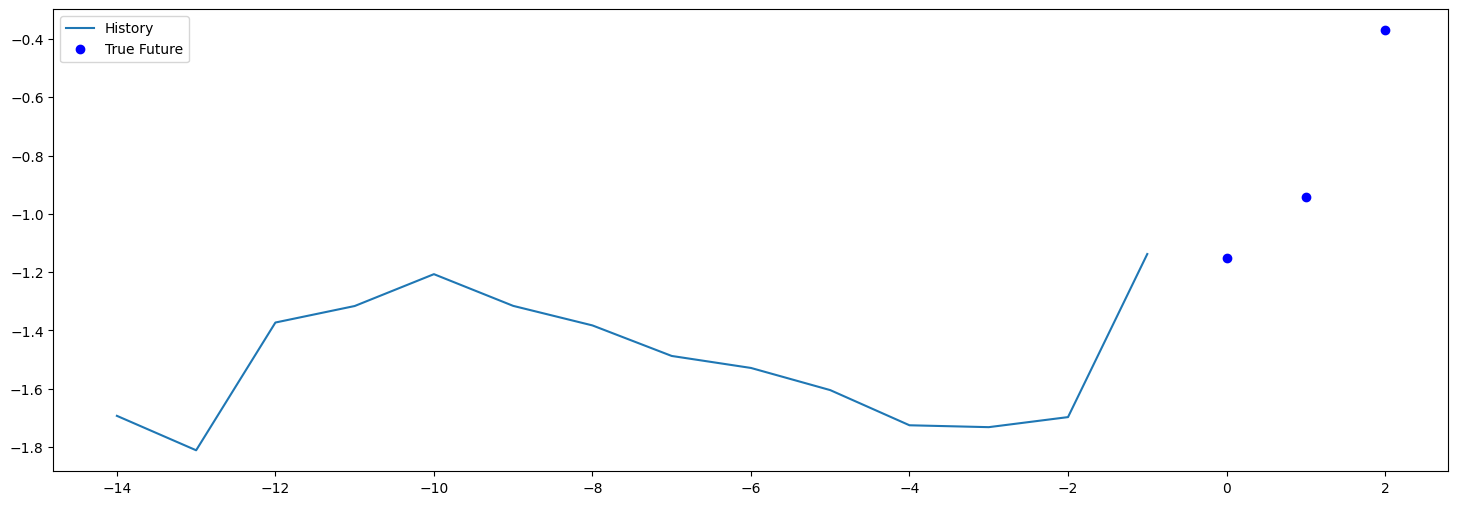

In [18]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]), STEP)

In [19]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(3))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
print(multi_step_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 14, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
print(val_data_multi)

for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 14, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
(120, 3)


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.5654 - val_loss: 0.3515
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.3405 - val_loss: 0.3290
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.3280 - val_loss: 0.3193
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.3181 - val_loss: 0.3004
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.3013 - val_loss: 0.2877
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2870 - val_loss: 0.2689
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2690 - val_loss: 0.2473
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2472 - val_loss: 0.2248
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2256 - val_loss: 0.2194
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2129 - val_loss: 0.1998
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1937 - val_loss: 0.1836
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 

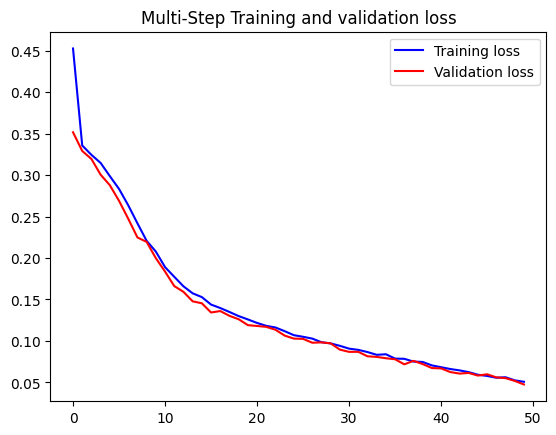

In [22]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[71.10838022 61.01958327 65.75425393]
[70.82722  61.734844 66.50059 ]
0.9008726709646713
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


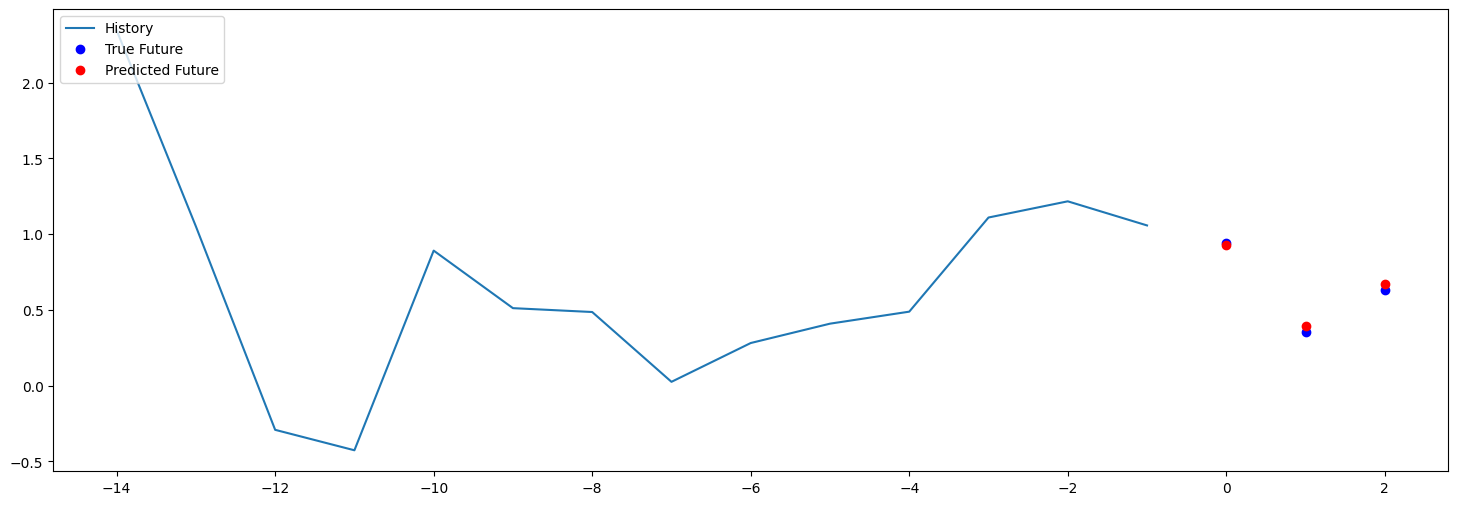

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[14.01809508 18.41666409 18.35654877]
[16.654583 18.930244 17.796223]
8.2162927067822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


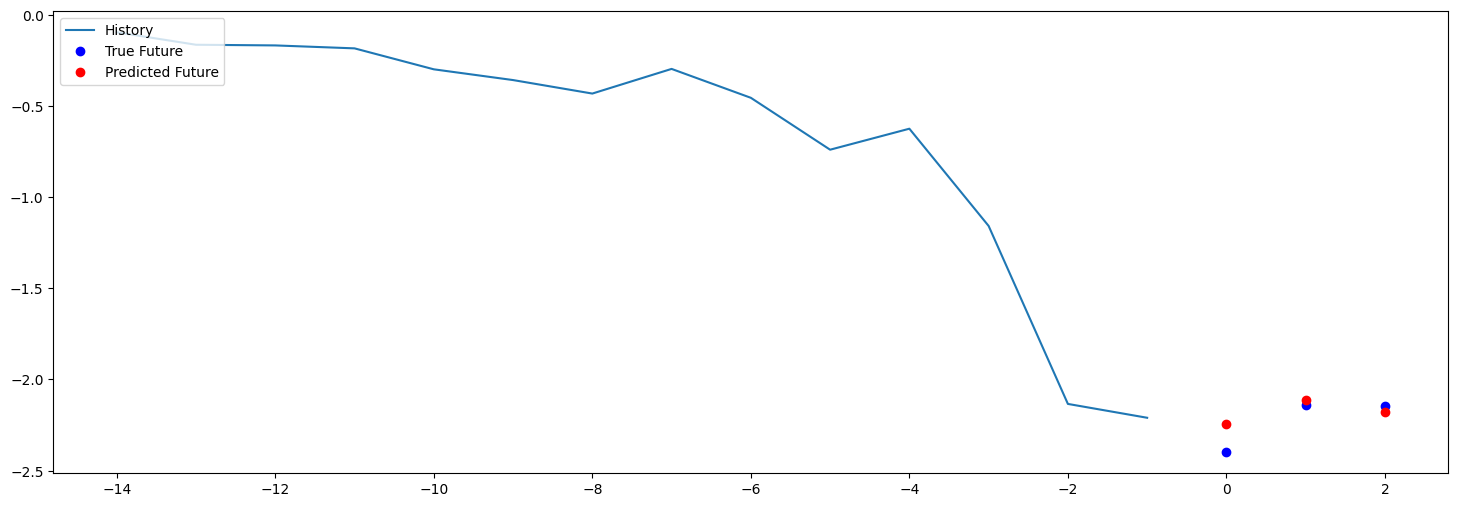

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[58.29470014 55.66821129 61.90478668]
[58.556263 55.417774 61.284374]
0.6335898048382217
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


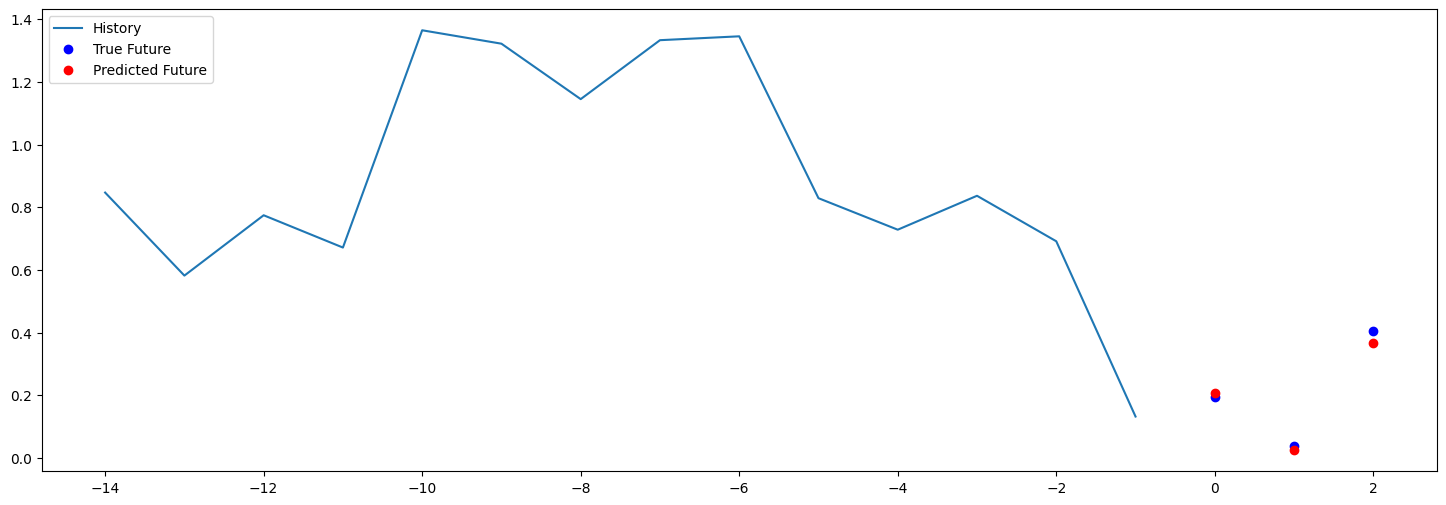

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[56.41340559 48.11685506 50.45750818]
[55.85554  48.666245 49.371662]
1.4275562636051347
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


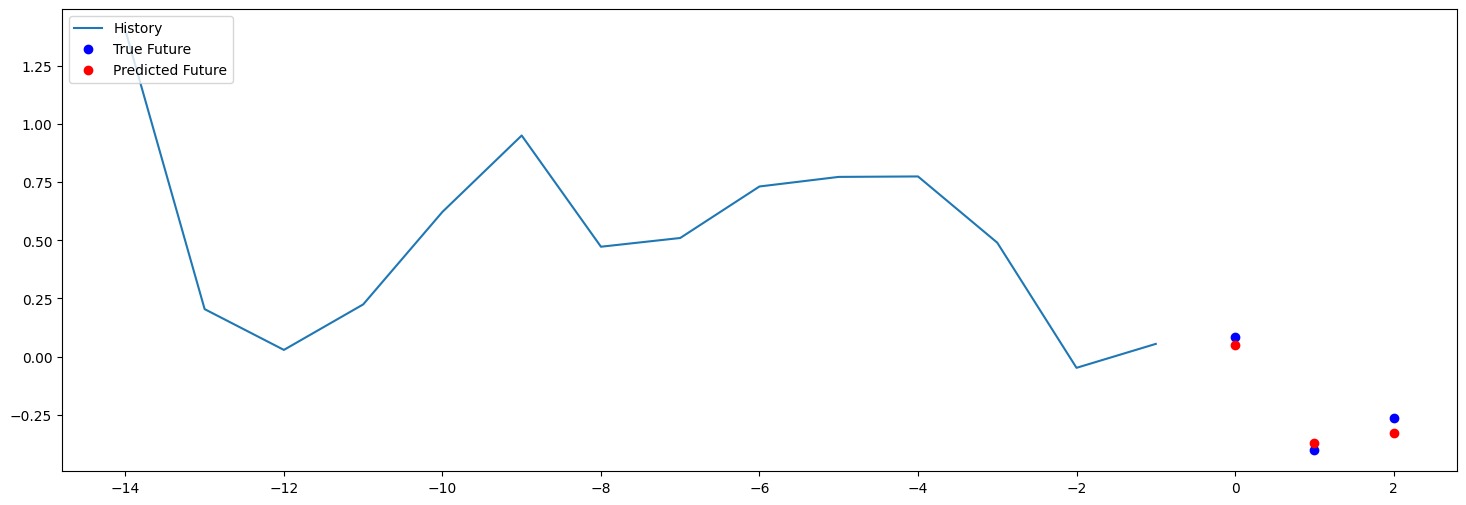

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[53.16064113 42.20473403 44.26111733]
[54.204903 42.49386  43.627407]
1.3603855261238413
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


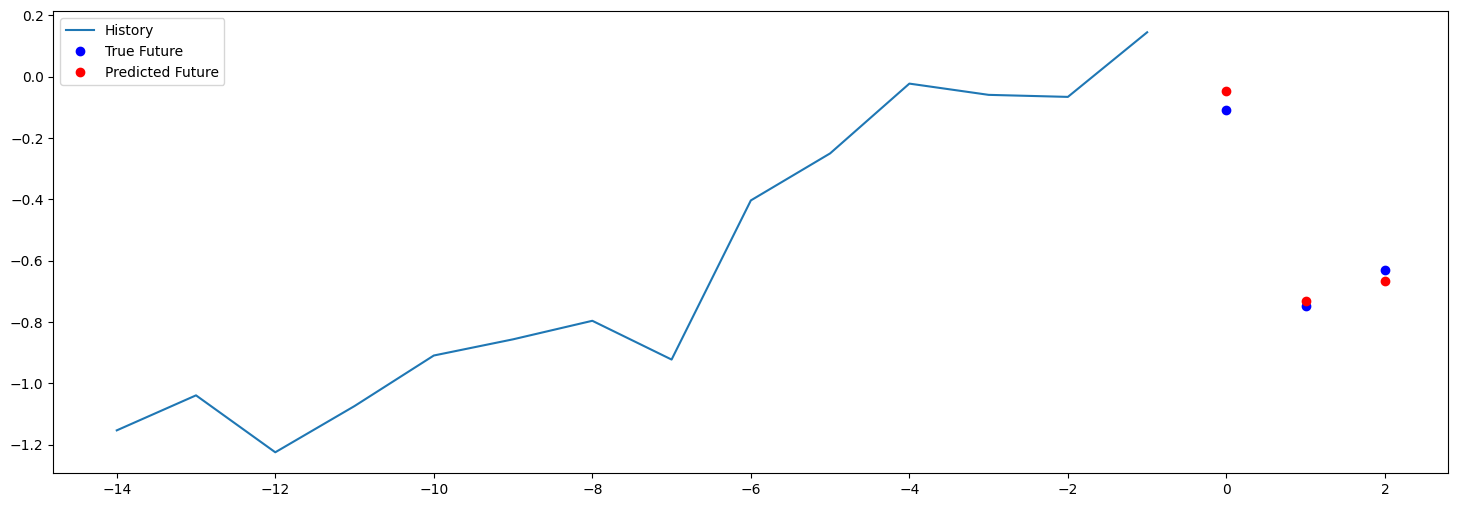

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[64.15727576 61.89086589 59.75223067]
[65.51665  61.832474 60.130836]
0.9489281449491106
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


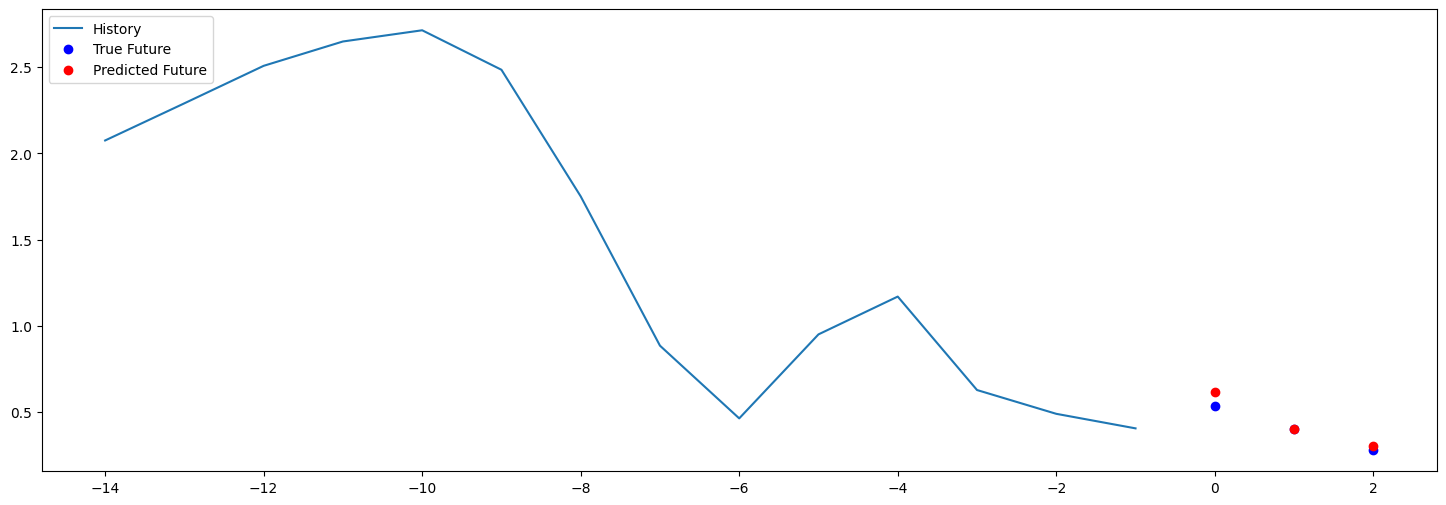

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[26.11532428 18.77625601 30.39884844]
[27.283472 20.43985  30.548971]
4.608990919041337
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


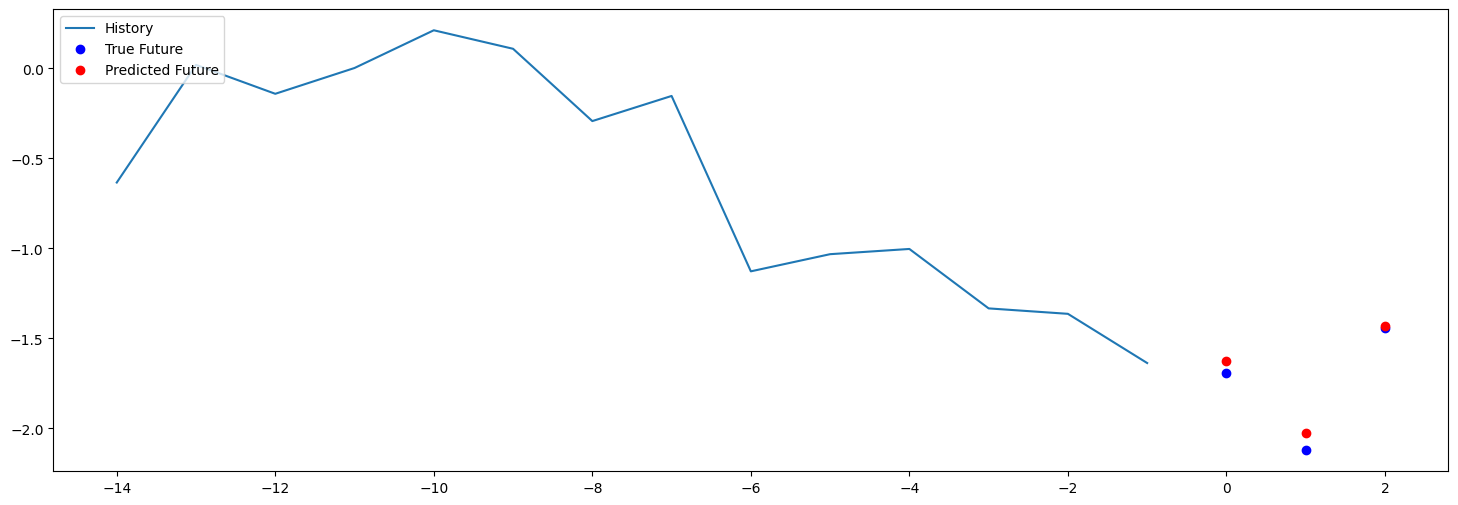

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[56.13960541 54.55990477 52.45193699]
[55.803886 54.455444 52.56744 ]
0.3365582909822222
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


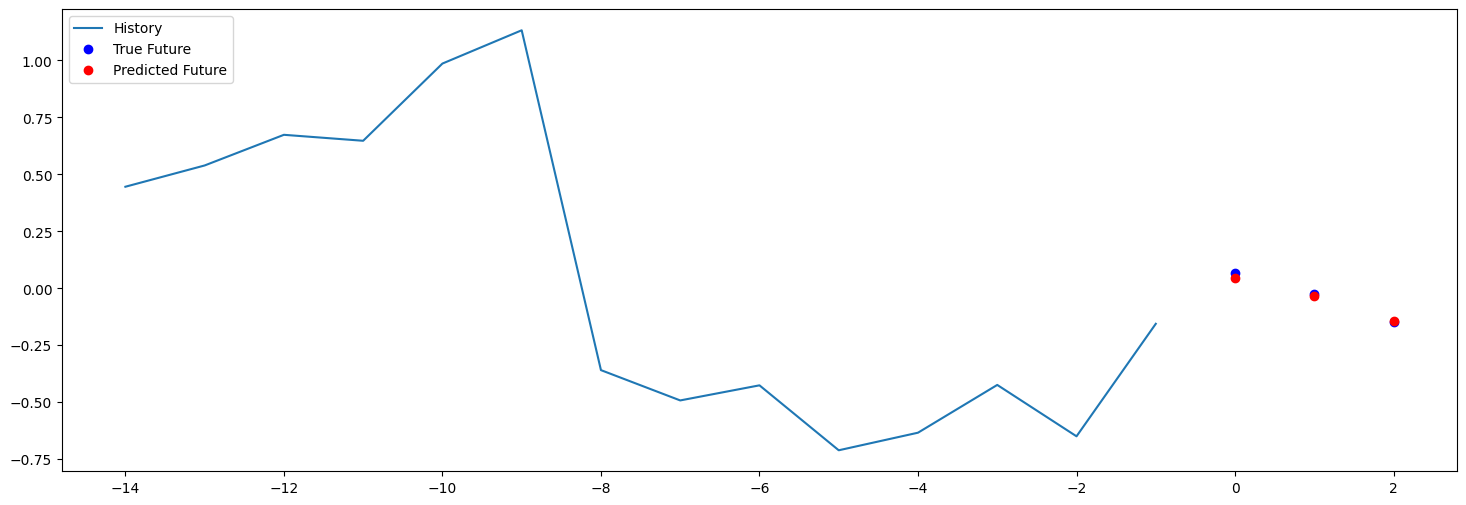

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[35.79818802 38.78027928 39.24931862]
[36.83542  39.17323  40.345703]
2.2346988165227484
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


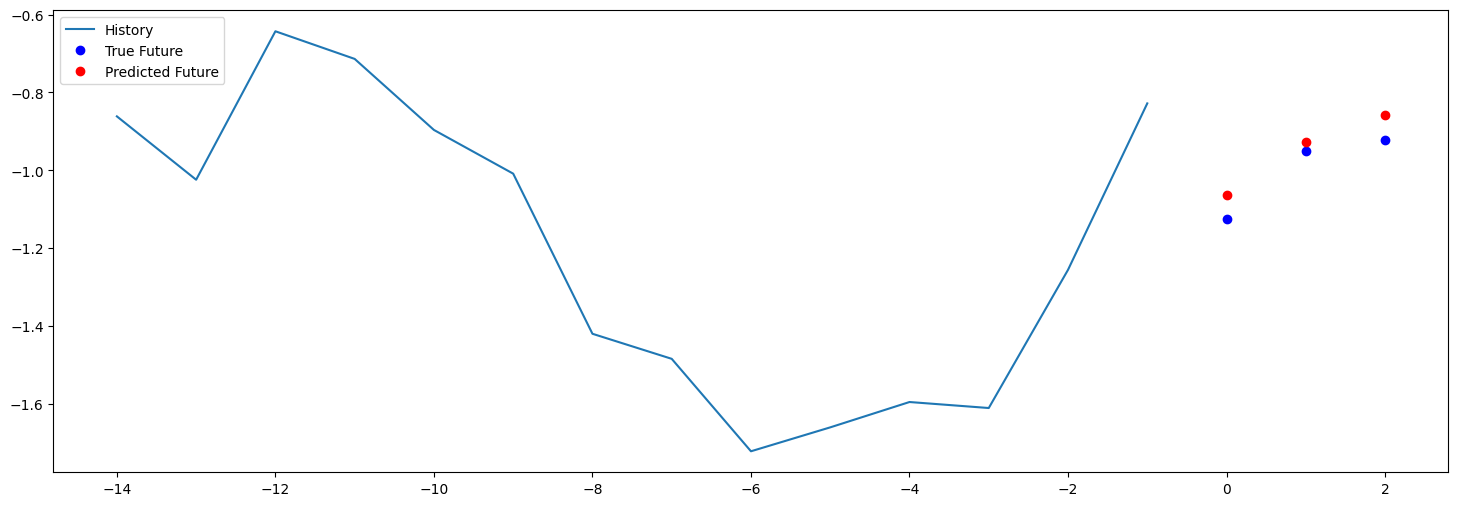

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[22.49401613 27.39923592 34.16630268]
[22.90031  27.748085 33.46028 ]
1.7152888273474467
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


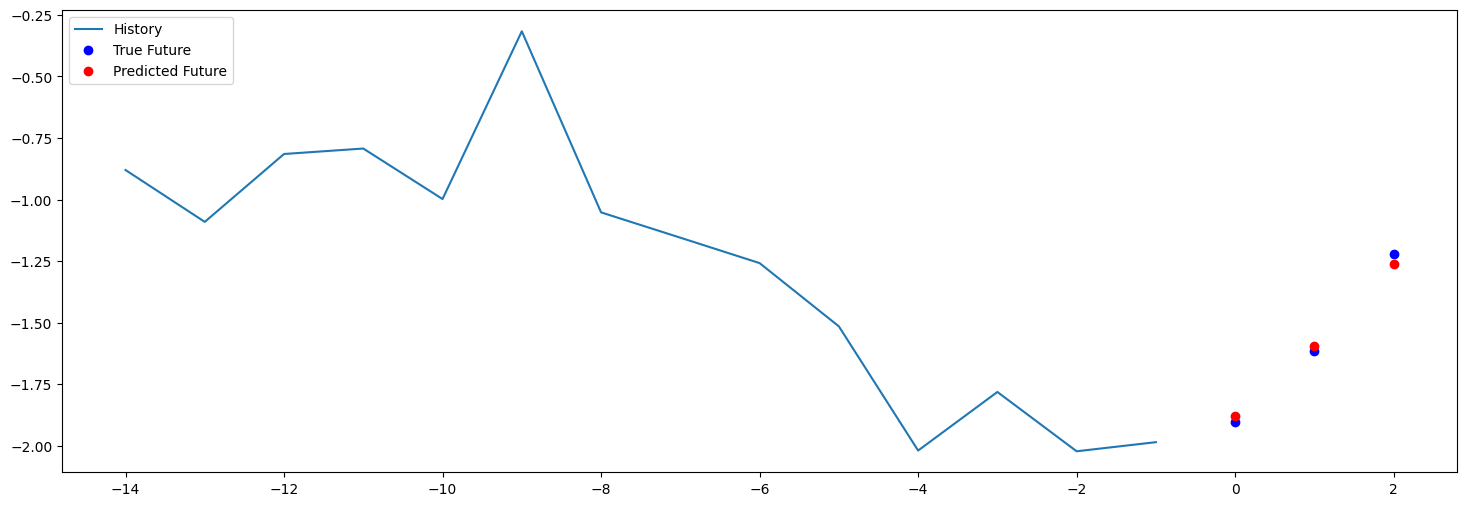

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[59.80581736 60.54276164 65.35653612]
[60.48257  61.959633 64.58351 ]
1.5515491029129698
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


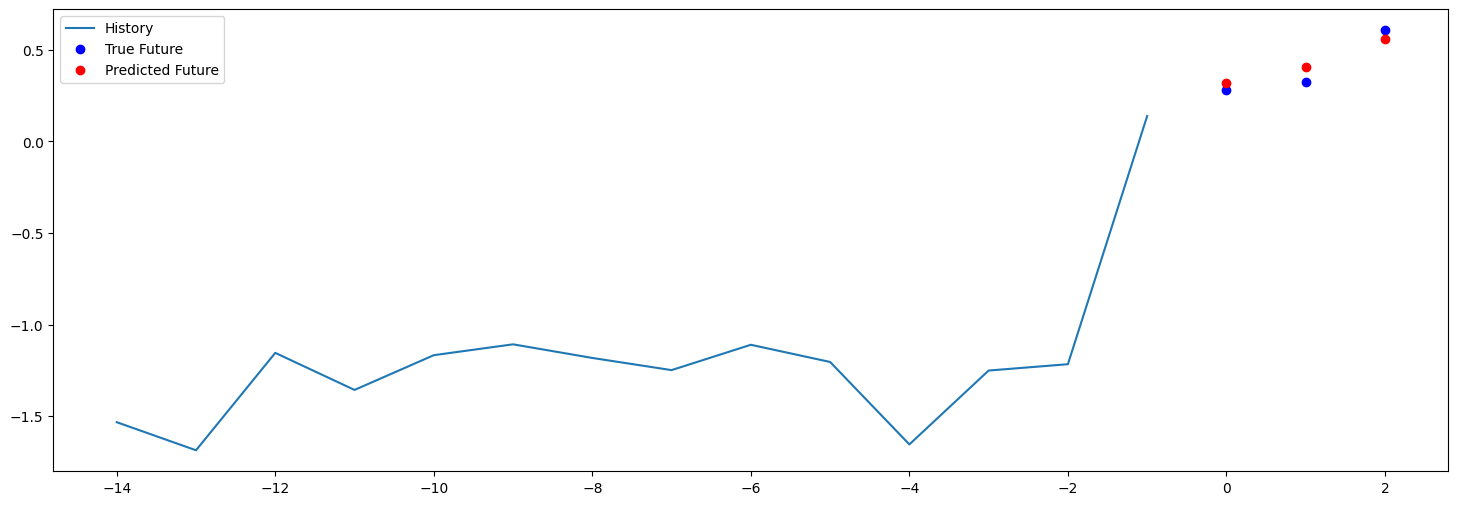

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[71.10838022 61.01958327 65.75425393]
[70.82722  61.734844 66.50059 ]
0.9008726709646713
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


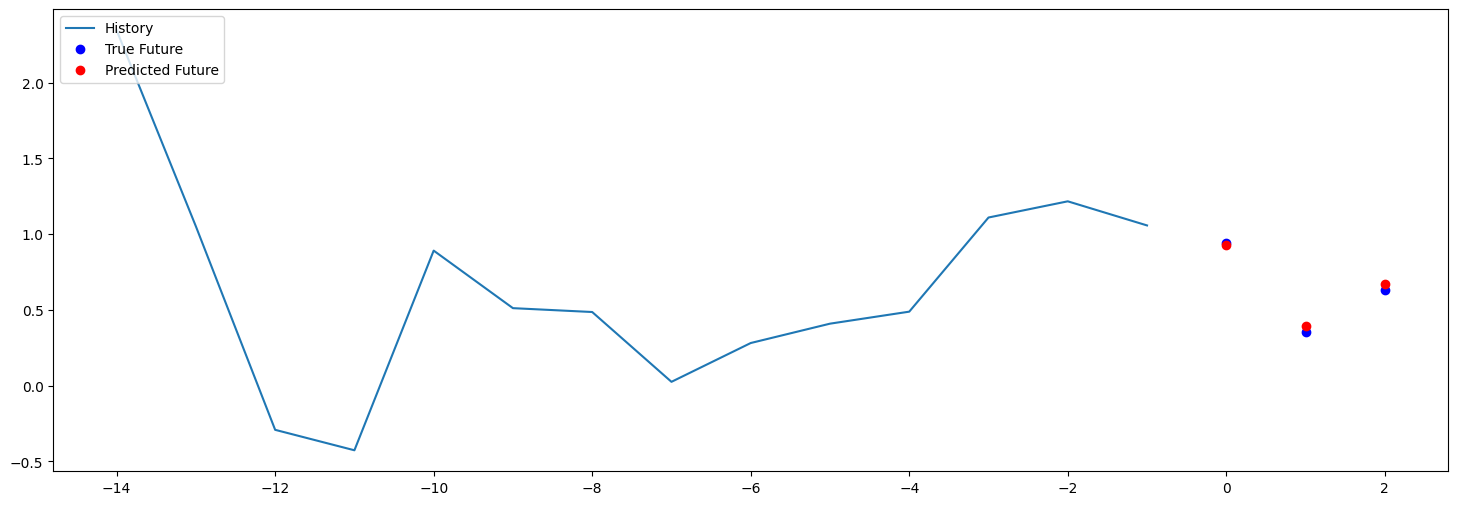

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[14.01809508 18.41666409 18.35654877]
[16.654583 18.930244 17.796223]
8.2162927067822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


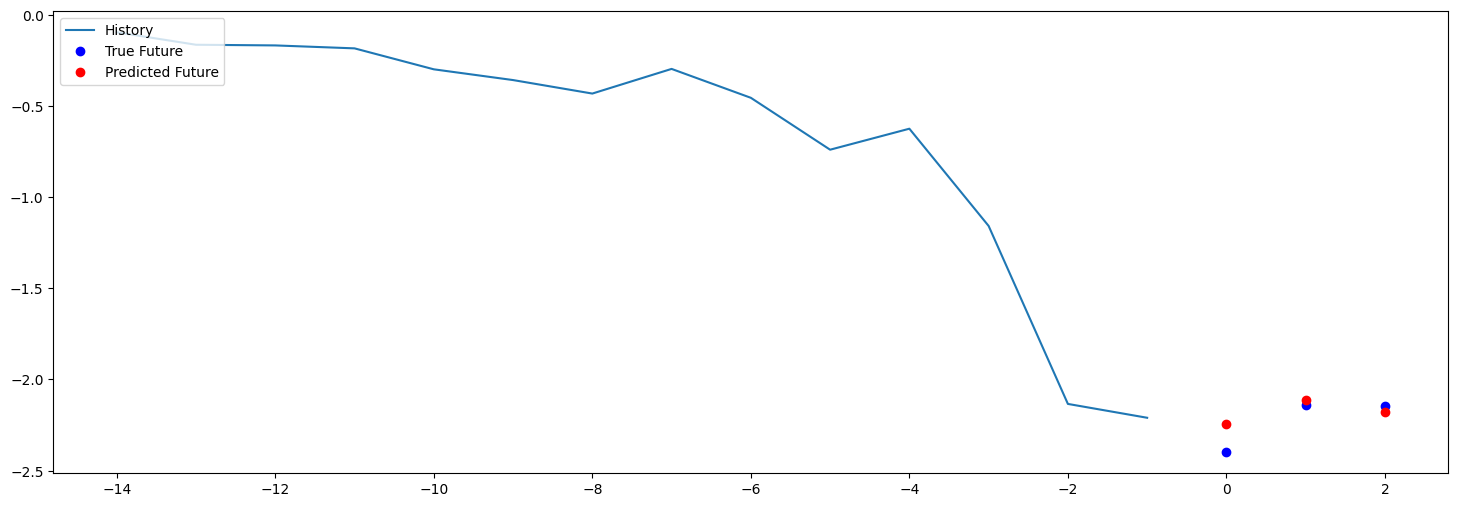

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[58.29470014 55.66821129 61.90478668]
[58.556263 55.417774 61.284374]
0.6335898048382217
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


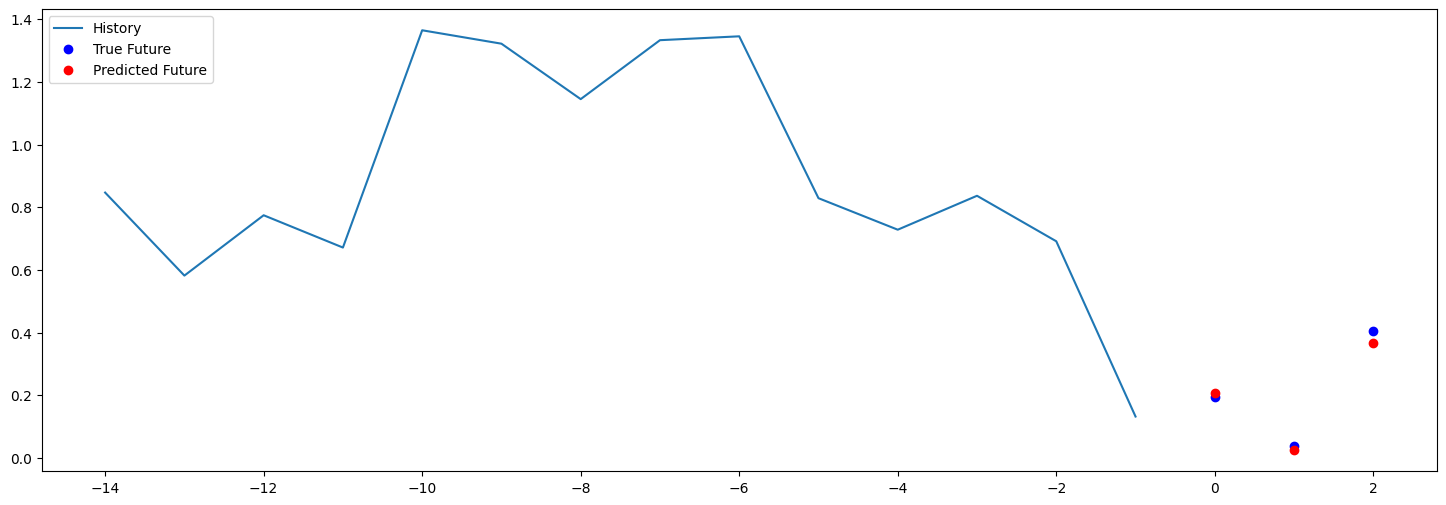

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[56.41340559 48.11685506 50.45750818]
[55.85554  48.666245 49.371662]
1.4275562636051347
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


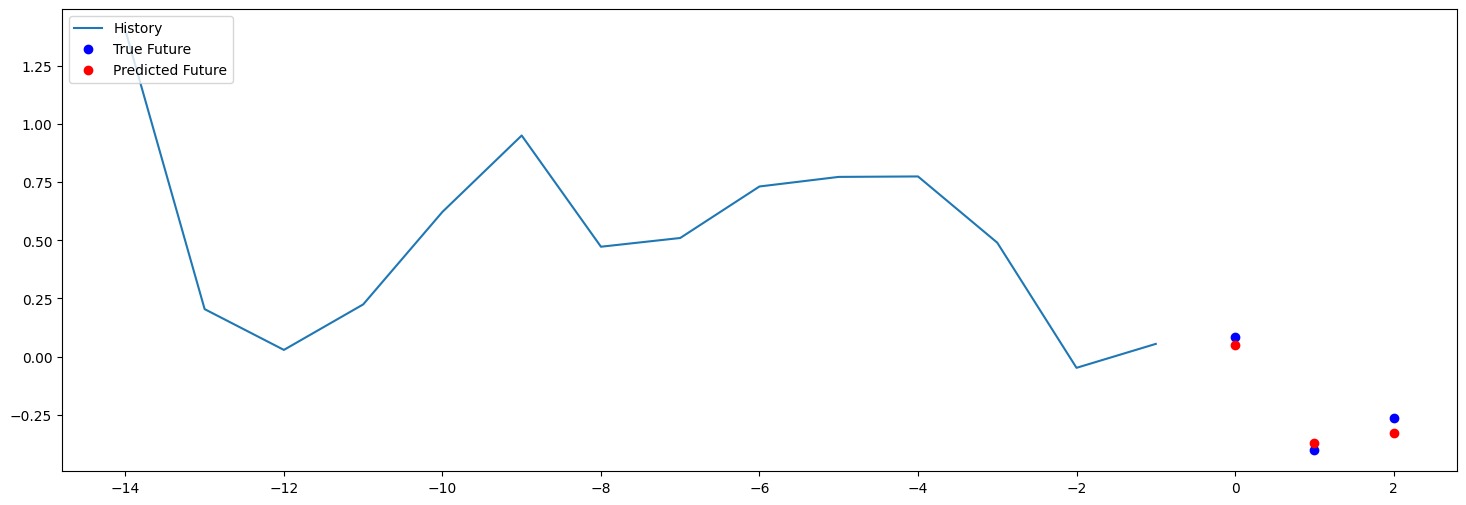

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[53.16064113 42.20473403 44.26111733]
[54.204903 42.49386  43.627407]
1.3603855261238413
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


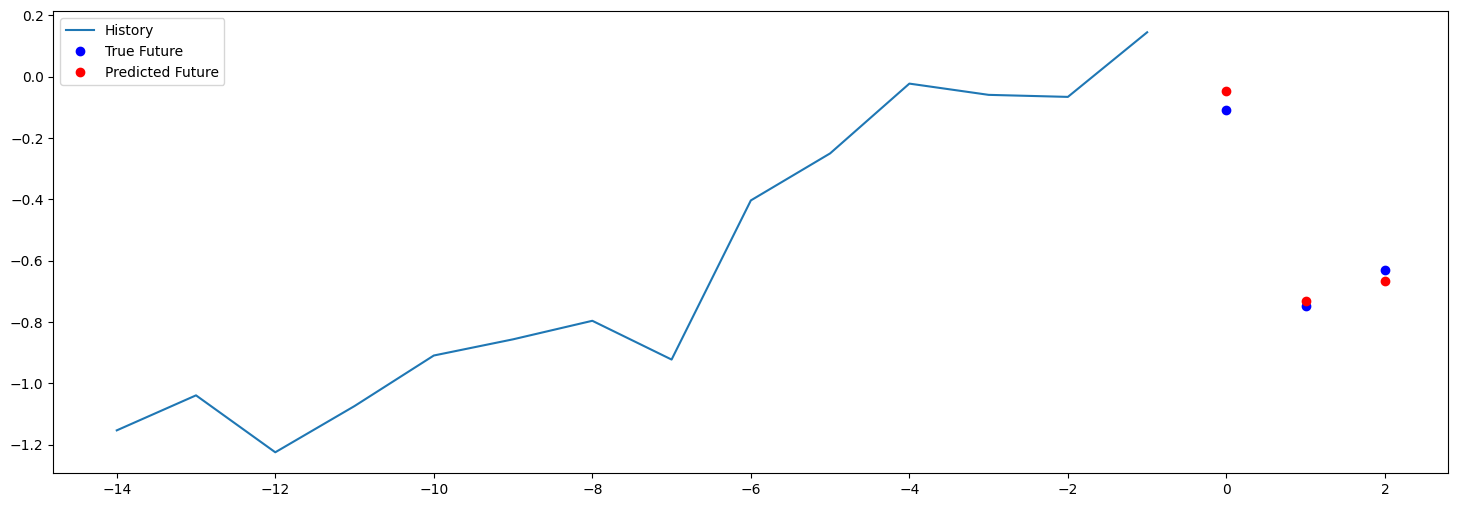

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[64.15727576 61.89086589 59.75223067]
[65.51665  61.832474 60.130836]
0.9489281449491106
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


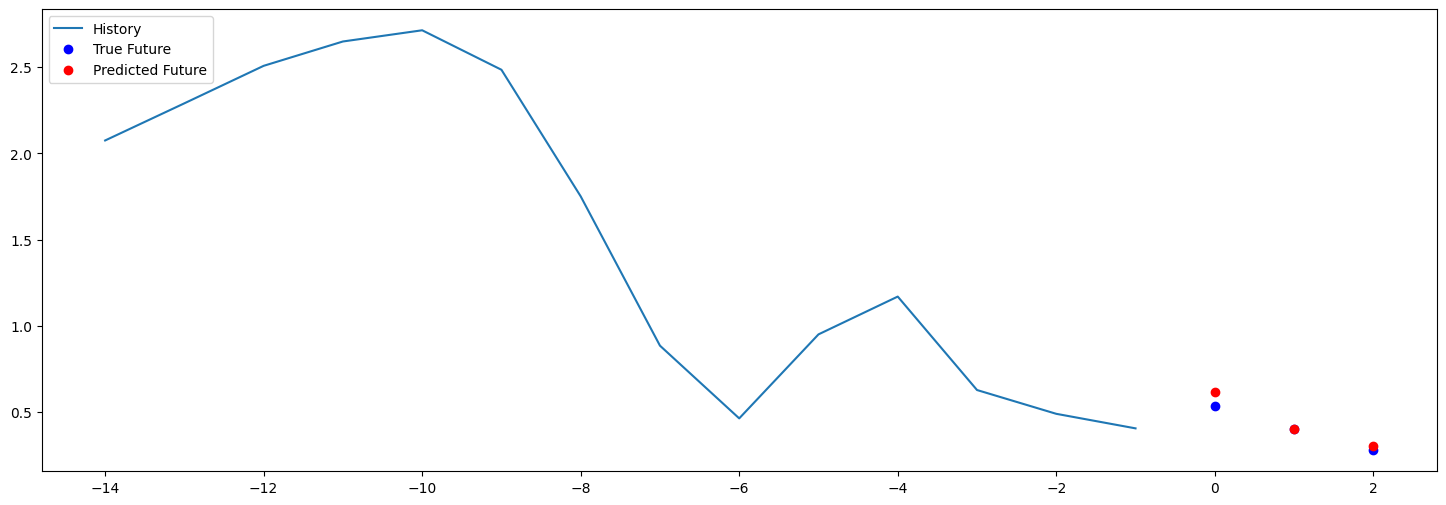

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[26.11532428 18.77625601 30.39884844]
[27.283472 20.43985  30.548971]
4.608990919041337
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


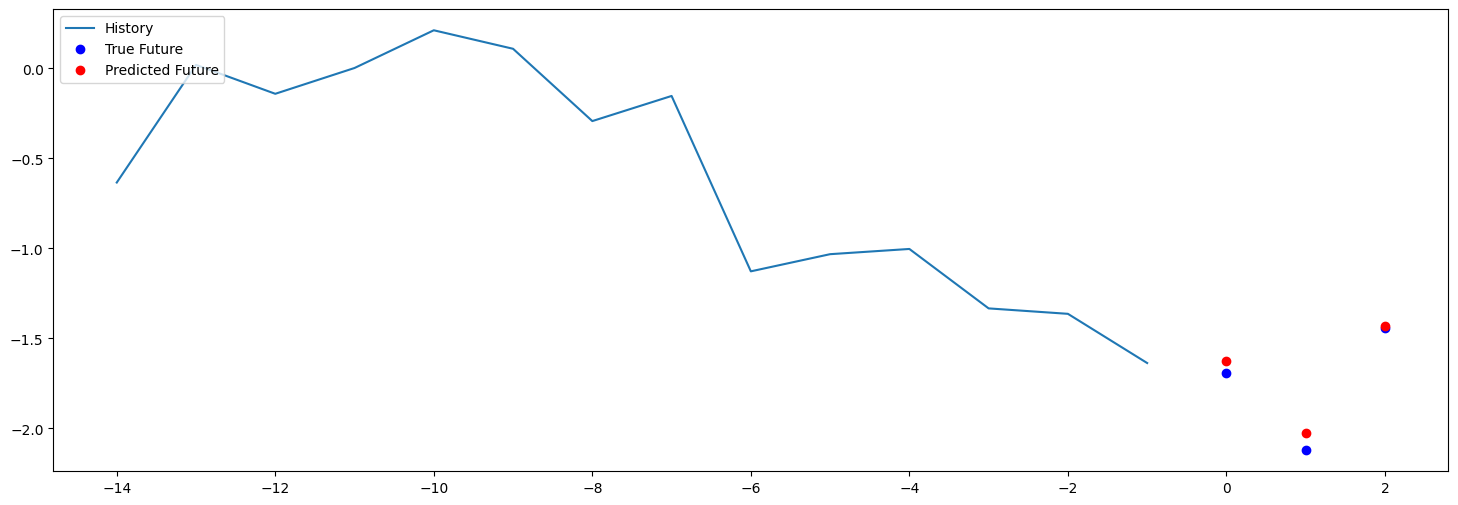

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[56.13960541 54.55990477 52.45193699]
[55.803886 54.455444 52.56744 ]
0.3365582909822222
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


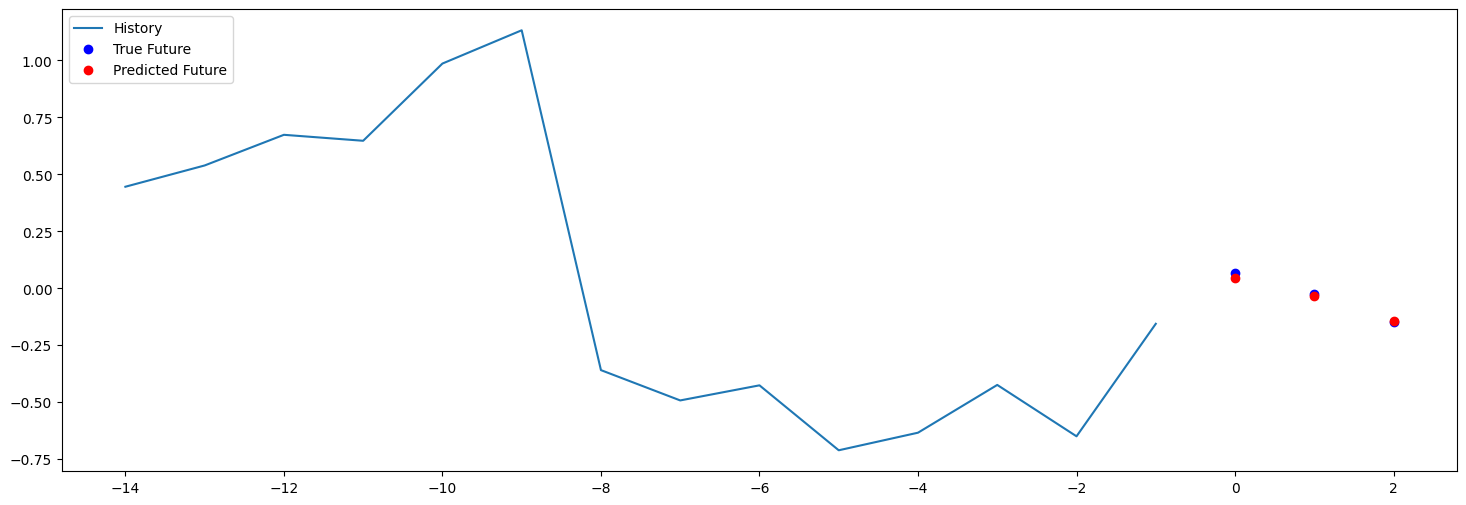

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[35.79818802 38.78027928 39.24931862]
[36.83542  39.17323  40.345703]
2.2346988165227484
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


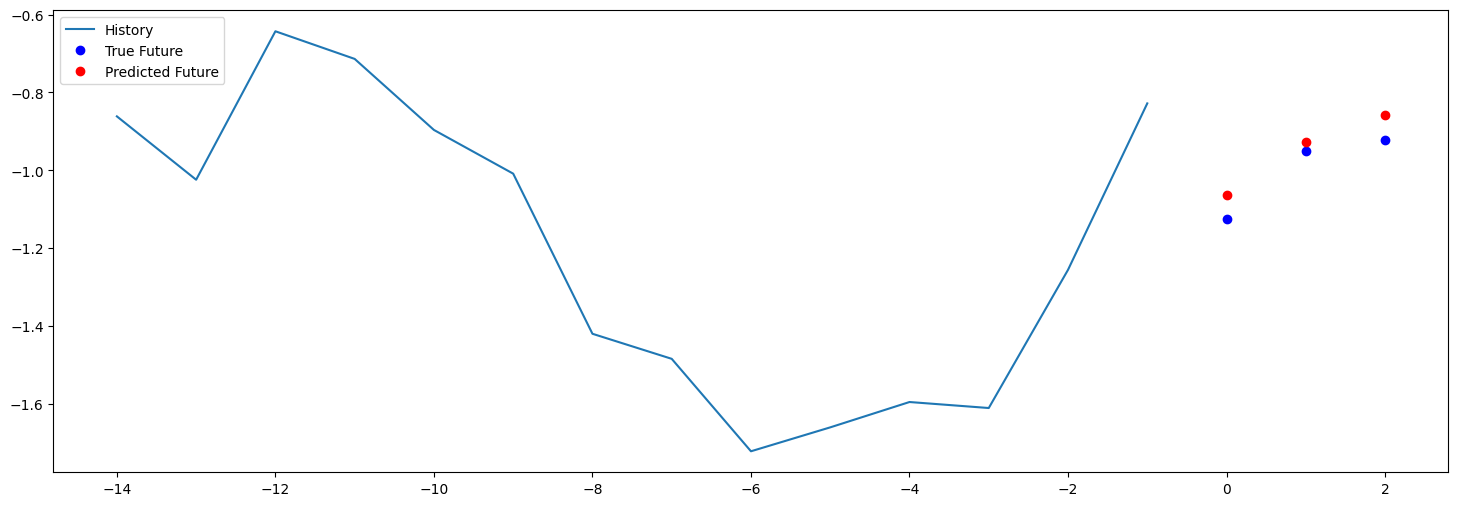

In [41]:
mape_list = []

for x, y in val_data_multi.take(20):
    predict = multi_step_model.predict(x)[0]
    original_vector_predict = np.array(predict).reshape(1, -1)
    predict_inv = scaler.inverse_transform(original_vector_predict)
    
    original_vector_true = np.array(y[0].numpy()).reshape(1, -1)
    true_inv = scaler.inverse_transform(original_vector_true)
    
    mape = calculate_mape(true_inv[0], predict_inv[0])
    mape_list.append(mape)
    
    print(true_inv[0])
    print(predict_inv[0])
    print(mape)
    
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], STEP)

average_mape = np.mean(mape_list)

In [42]:
print(average_mape)

2.2301292108939696


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[-0.70825183 -0.6290265  -0.81805044]


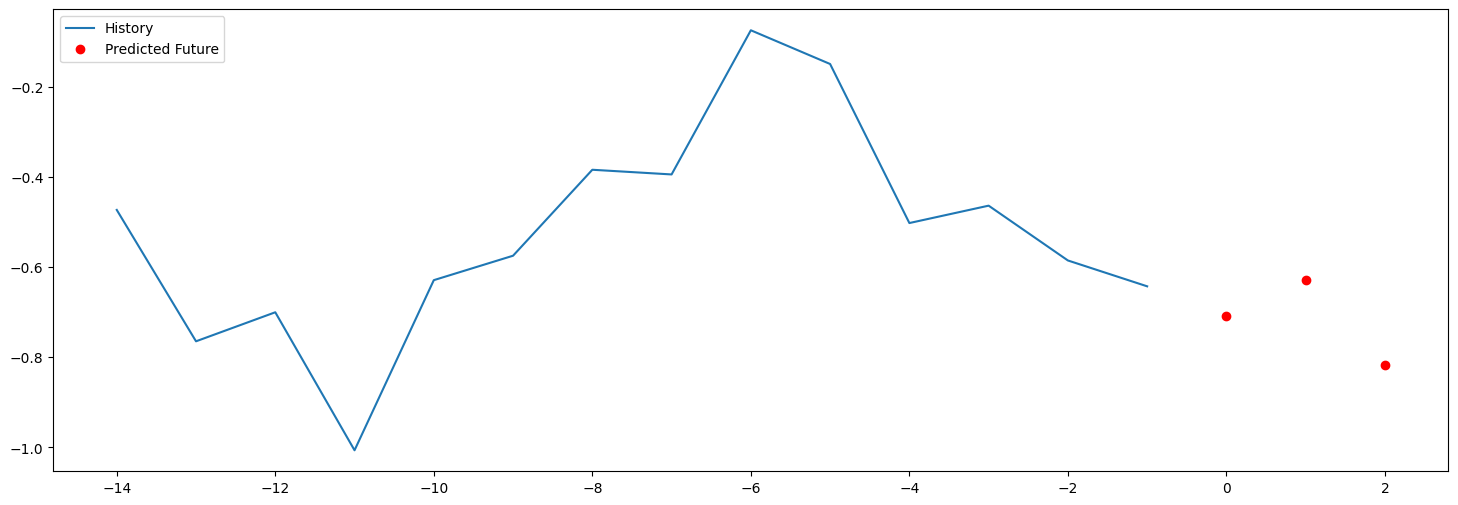

[[42.97727  44.08259  41.445404]]


In [24]:
# FORECAST

forecast_df = scaled_df[-28:]

x_input, _ = multivariate_data(forecast_df.values, scaled_df.iloc[:, 2], 0, 29, 14, 0, 1)

# Створюємо датасет з масиву numpy
BATCH_SIZE = 120
forecast_val = tf.data.Dataset.from_tensor_slices((x_input))
forecast_val = forecast_val.batch(BATCH_SIZE).repeat()

# Визначаємо функцію для побудови графіку без виведення значень true_future
def multi_step_plot_no_true(history, prediction, step):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction)

    plt.plot(num_in, np.array(history[:, 2]), label='History')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# print(forecast_val)
# # Виводимо кожен елемент датасету та робимо прогноз
for x in forecast_val.take(1):
    predict = multi_step_model.predict(x)[0]
    print(predict)
    multi_step_plot_no_true(x[0], predict, STEP)
    original_vector = np.array(predict).reshape(1, -1)
    predict_inv = scaler.inverse_transform(original_vector)
    data_inv = scaler.inverse_transform(forecast_df)
    print(predict_inv)

In [25]:
rsi_data = btc_data_df["rsi_14"].values.reshape(-1, 1)
rsi_data_s = scaled_df["rsi_14"].values.reshape(-1, 1)
rsi_scaled_test = np.array([-0.10770183, -0.74921406, -0.62880458]).reshape(-1, 1)
rsi_scaled_test_1 = np.array([-0.3126077, -0.70279479, -0.71893308]).reshape(-1, 1)

rsi_scaled = scaler.fit_transform(rsi_data)

# print(rsi_data)
print(scaler.inverse_transform(rsi_data_s))
print(scaler.inverse_transform(rsi_scaled_test))

[[85.57559066]
 [67.52253809]
 [48.79539758]
 ...
 [48.49713872]
 [43.05340363]
 [42.82824868]]
[[51.35590392]
 [42.40578043]
 [44.0856856 ]]
